## АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ

Представьте, что вы — Data Scientist в туристической фирме. Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные — скачайте их по ссылке ниже.

[Скачать данные](https://lms-cdn.skillfactory.ru/assets/courseware/v1/3274d20d12cca49b6ce3d18d75ba8826/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_data_tourist.zip)

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — **конверсии покупки** и **ежедневному среднему чеку**.

Вы должны убедиться, что A/B-тестирование было проведено корректно, проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?

Итак, компания предлагает следующие варианты туров:
- Таиланд — 100 000 рублей;
- Турция — 60 000 рублей;
- Мальдивы — 200 000 рублей;
- Санкт-Петербург — 10 000 рублей;
- Камчатка — 150 000 рублей.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats import proportion
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import t

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
url = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/3274d20d12cca49b6ce3d18d75ba8826/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_data_tourist.zip'
data = pd.read_csv(url)
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Наша таблица представлена следующими полями:
- *user_id* — идентификатор пользователя, зашедшего на сайт;
- *data* — дата посещения сайта;
- *group* — группа теста (контрольная — А или тестовая — B);
- *purchase* — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
- *price* — цена купленного тура (если покупка не состоялась, цена равна 0).

### Задание 1.

Проанализируйте структуру данных и проведите их предобработку:
- исследуйте структуру данных;
- преобразуйте столбцы к необходимым типам данных.
- Убедитесь в одинаковой длительности проведения A/B-тестирования в каждой из групп. Если длительность разная, унифицируйте данные, удалив лишние данные для соответствующей группы.
- Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.
- Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах.

In [3]:
# посмотрим информацию по таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Пропуски отсутствуют.

In [4]:
# преобразуем поле date
data['date'] = pd.to_datetime(data['date'])

In [5]:
#Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе группы.
list_of_users_a = set(data[data['group'] == 'A']['user_id'])
list_of_users_b = set(data[data['group'] == 'B']['user_id'])
user_intersection = list_of_users_a & list_of_users_b
print('Количество пользователей попавших в обе группы:', len(user_intersection))

Количество пользователей попавших в обе группы: 1895


In [6]:
# удаляем
data = data[~data['user_id'].isin(user_intersection)]

In [7]:
# Убедимся в одинаковой длительности проведения A/B-тестирования в каждой из групп

# дата начала
date_min_a = data[data['group'] == 'A']['date'].min()
date_min_b = data[data['group'] == 'B']['date'].min()

# дата окончания
date_max_a = data[data['group'] == 'A']['date'].max()
date_max_b = data[data['group'] == 'B']['date'].max()

# количество дней
quantity_of_days_a = len(data[data['group'] == 'A']['date'].unique())
quantity_of_days_b = len(data[data['group'] == 'B']['date'].unique())

# проверим на совпадение даты начала и окончания теста и число дней
if date_min_a == date_min_b and date_max_a == date_max_b and  quantity_of_days_a == quantity_of_days_b:
    print('Длительность совпадает')
else:
    print('Длительность не совпадает')


Длительность совпадает


### Задание 2.

Сделайте первичный анализ результатов A/B-тестирования:

Рассчитайте вспомогательные показатели для контрольной и тестовой групп:
- количество посещений сайта;
- суммарное количество совершённых покупок;
- сумма всех покупок.

Сделайте промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной страницы? Можно ли говорить о сбалансированности выборок?

В каждой из групп рассчитайте ключевые показатели:
- конверсия;
- средний чек.

Сделайте первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего чека в каждой из групп. По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот?

Сравните варианты A/B по покупательской способности каждого из туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. Визуализируйте полученную сводную таблицу.

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем покупательская способность участников группы B, и наоборот?

In [8]:
# Количество посещений
visit_count_a = data[data['group'] == 'A'].shape[0]
visit_count_b = data[data['group'] == 'B'].shape[0]

# Конверсия
conversion_a = round(data[data['group'] == 'A']['purchase'].sum() / data[data['group'] == 'A'].shape[0] * 100, 2)
conversion_b = round(data[data['group'] == 'B']['purchase'].sum() / data[data['group'] == 'B'].shape[0] * 100, 2)

# Средний чек
average_check_a = round(data[data['group'] == 'A']['price'].sum() / data[data['group'] == 'A']['purchase'].sum(), 2)
average_check_b = round(data[data['group'] == 'B']['price'].sum() / data[data['group'] == 'B']['purchase'].sum(), 2)

In [9]:
# сделаем таблицу для наглядности

df = pd.DataFrame(
    {
        'Группа': ['A', 'B'],
        'Кол-во посещений': [visit_count_a, visit_count_b],
        'Конверсия': [conversion_a, conversion_b],
        'Средний чек': [average_check_a, average_check_b]
    }
)

display(df)

print('Абсолютная разница в количестве посещений посадочной страницы:', visit_count_b - visit_count_a)
print(f'В процентах: {round((visit_count_b - visit_count_a) / visit_count_a * 100, 2)}%')

,Группа,Кол-во посещений,Конверсия,Средний чек
0,A,145307,12.03,81076.23
1,B,145381,11.89,88664.55


Абсолютная разница в количестве посещений посадочной страницы: 74
В процентах: 0.05%


Количество посещений обоих вариантов посадочной страницы сопоставимо, можно говорить о сбалансированности выборок.  
По показателю конверсии вариант А эффективнее.  
А по показателю среднего чека эффективнее вариант B

In [10]:
# Сравните варианты A/B по покупательской способности каждого из туров. 
# Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 
# Визуализируйте полученную сводную таблицу.

pivot_df = pd.pivot_table(
    data[data['price'] > 0],
    values='user_id',
    index=['group'],
    columns=['price'],
    aggfunc='count'
)
pivot_df

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


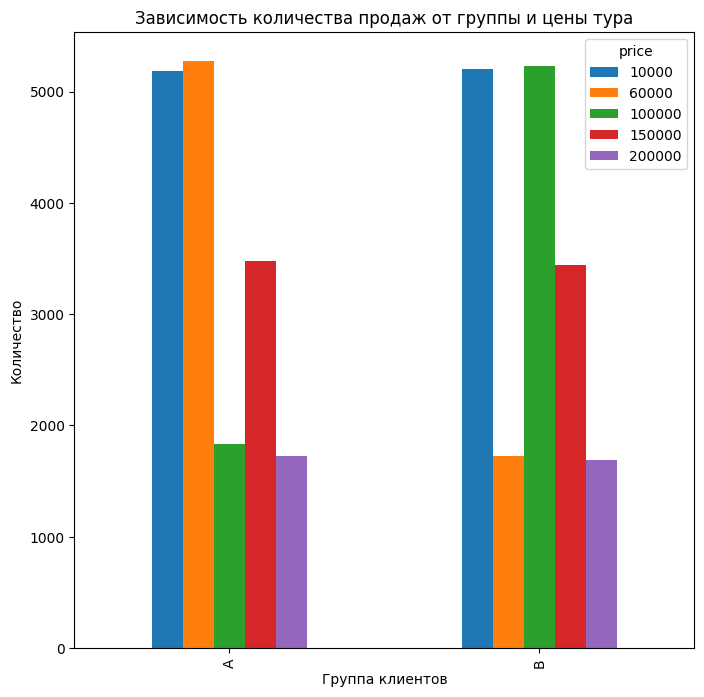

In [11]:
fig, axes = plt.subplots(figsize=(8, 8))
pivot_df.plot(kind='bar', ax=axes)
axes.set_title('Зависимость количества продаж от группы и цены тура')
axes.set_xlabel('Группа клиентов')
axes.set_ylabel('Количество');

На графике видно, что в группе А наиболее популярны туры за 10 и 60 тыс. рублей (Санкт-Петербург и Турция), а в группе В туры в Турцию не так популярны и клиенты из этой группы предпочитают Турции, более дорогие туры, стоимостью 100 тыс. рублей (Таиланд). Самые дорогие туры, за 150 и 200 тыс. рублей (Камчатка и Мальдивы) одинаково популярны в обеих группах.


### Задание 3.

Проанализируйте данные на предмет стабилизации метрик:

Сгруппируйте данные по дате и группе тестирования и постройте таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислите ежедневные показатели:
- количество посещений страницы;
- количество покупок;
- сумму покупок.

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

Рассчитайте кумулятивные показатели:
- кумулятивное количество посещений страницы;
- кумулятивное количество покупок;
- кумулятивную сумму покупок.

На основе полученных кумулятивных показателей вычислите кумулятивную конверсию и кумулятивный средний чек.

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням.

Сделайте выводы. Можно ли назвать A/B-тест завершённым? Стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [12]:
# Сгруппируем по дате и группе и рассчитаем ежедневные показатели

daily_data = data.groupby(['date','group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'visit_count', 'purchase': 'number_of_purchases', 'price': 'purchase_sum'})

#daily_data.head()

In [13]:
# Расчитаем конверсию и средний чек
daily_data['conversion'] = daily_data['number_of_purchases'] / daily_data['visit_count'] * 100
daily_data['average_check'] = daily_data['purchase_sum'] / daily_data['number_of_purchases']
daily_data.head()

,date,group,visit_count,number_of_purchases,purchase_sum,conversion,average_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


In [14]:
# Расчитаем кумулятивные метрики

# кумулятивное количество посещений страницы
daily_data['cum_visit_count'] = daily_data.groupby(['group'])['visit_count'].cumsum()

# кумулятивное количество покупок
daily_data['cum_number_of_purchases'] = daily_data.groupby(['group'])['number_of_purchases'].cumsum()

# кумулятивная сумма покупок
daily_data['cum_purchase_sum'] = daily_data.groupby(['group'])['purchase_sum'].cumsum()

daily_data.head()

,date,group,visit_count,number_of_purchases,purchase_sum,conversion,average_check,cum_visit_count,cum_number_of_purchases,cum_purchase_sum
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000


In [15]:
# вычислим кумулятивную конверсию и кумулятивный средний чек
daily_data['cum_conversion'] = daily_data['cum_number_of_purchases'] / daily_data['cum_visit_count'] * 100
daily_data['cum_average_check'] = daily_data['cum_purchase_sum'] / daily_data['cum_number_of_purchases']

daily_data.head()

,date,group,visit_count,number_of_purchases,purchase_sum,conversion,average_check,cum_visit_count,cum_number_of_purchases,cum_purchase_sum,cum_conversion,cum_average_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


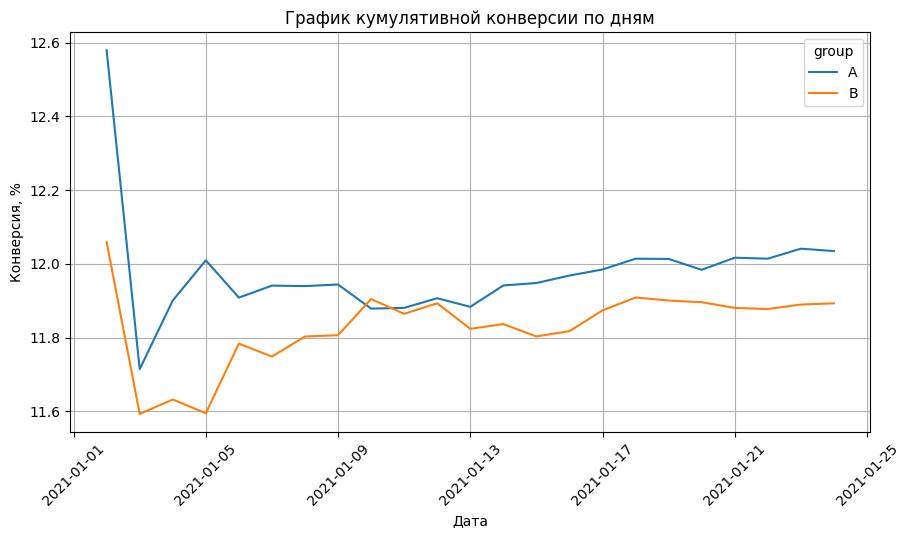

In [16]:
# Построим кумулятивный график конверсии

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Конверсия, %')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

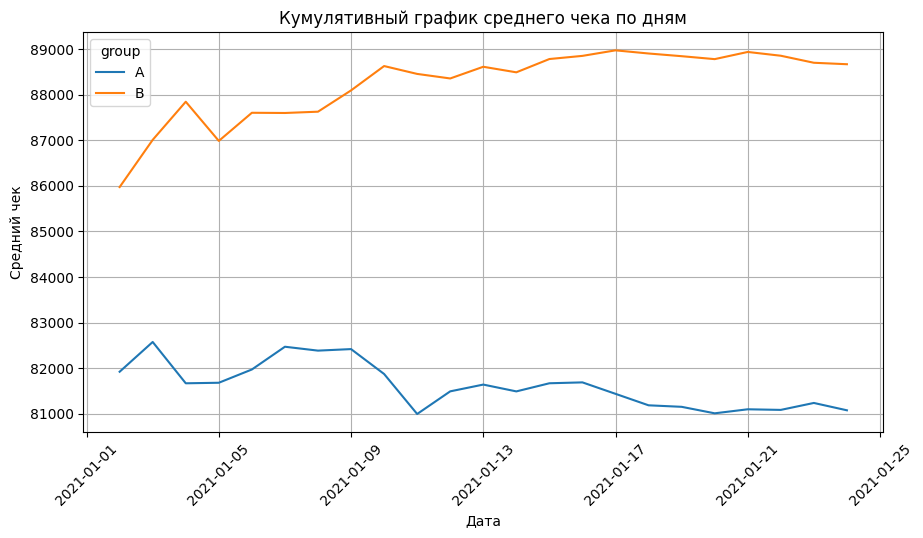

In [17]:
# Построим кумулятивный график среднего чека

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_average_check', data=daily_data, hue='group', ax=ax)
ax.set_title('Кумулятивный график среднего чека по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Средний чек')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

Значения метрик стабилизировались.  
Судя по графику кумулятивной конверсии, сначала конверсия была нестабильна, но после 11.01.2021 она выравнивается. И конверсия по группе В становися стабильно ниже чем по группе А. 
При этом график кумулятивного среднего чека показывает, что по группе В средний чек, стабильно выше на всем промежутке времени.

Для окончания A/B-тестирования, нам осталось провести статистический анализ результатов A/B-тестирования.

### Задание 4.

Проведите статистический анализ результатов A/B-тестирования:
- Сформулируйте статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберите статистический тест для их проверки.  
Не забудьте проверить данные на нормальность там, где это необходимо.  
- С помощью аппарата статистических тестов определите:
    - Есть ли статистическая разница между конверсиями в группах А и B?
    - Есть ли статистическая разница между ежедневными средними чеками в группах А и B?  
- Подкрепите результаты статистических тестов, построив 95 % доверительные интервалы для:
    - конверсий в каждой из групп;
    - разницы конверсий в группах;
     -ежедневного среднего чека в каждой из групп.
- Проинтерпретируйте построенные доверительные интервалы для конверсий и ежедневного среднего чека в группах. Есть ли перекрытие между доверительными интервалами для групп? Если есть, то о чём это говорит?

Выдвитем следующие гипотезы:
- Нулевая (отсутствие эффекта): конверсии в обеих группа равны $H_0:p_a = p_b$
- Альтернативная (наличие эффекта): конверсии в группах не равны $H_1:p_a \neq p_b$

In [18]:
# построим вспомогательную таблицу
conversion_piv= data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

conversion_piv

,sum,count
group,,
A,17487,145307
B,17290,145381


In [19]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=conversion_piv['sum'], #число «успехов»
    nobs=conversion_piv['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


Так как Z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза не подтверждается статистически.

Соответственно, разницы между вариантами посадочной страницы нет — они одинаковы по метрике конверсии.

Теперь давайте воспользуемся $\chi^2$ -тестом для оценки разницы в пропорциях.

Выдвинем следующие гипотезы:
- Нулевая (отсутствие эффекта): конверсии в группах A и B равны. $H_0:p_a = p_b$
- Альтернативная (наличие эффекта): конверсии в группах A и B не равны. $H_1:p_a \neq p_b$

In [20]:
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=conversion_piv['sum'], #число «успехов»
    nobs=conversion_piv['count'] #общее число наблюдений
)
# выводим результат
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


$\chi^2$-тест показал тот же результат, что и Z-тест. По метрике конверсии посадочные страницы одинаковы.

Теперь проведем статистический тест для показателя средний чек.

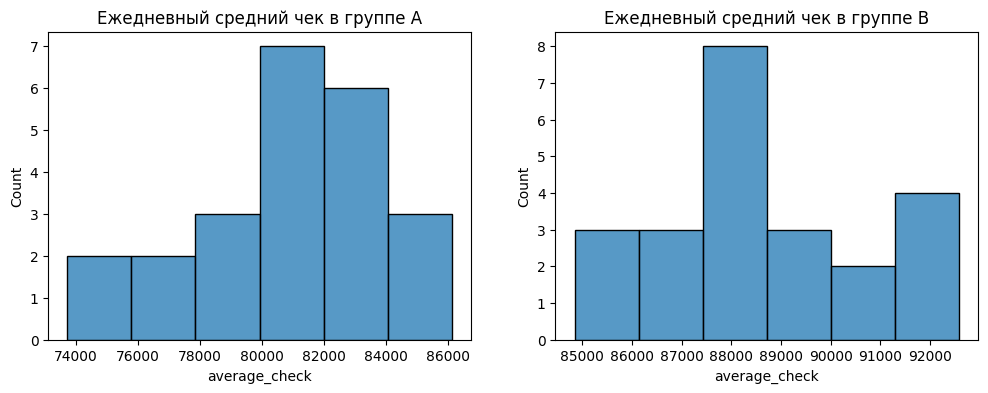

In [21]:
# Построим гистограмму ежедневного среднего чека в каждой из групп:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(x='average_check', data=daily_data[daily_data['group'] == 'A'], ax=axes[0])
sns.histplot(x='average_check', data=daily_data[daily_data['group'] == 'B'], ax=axes[1])

axes[0].set_title('Ежедневный средний чек в группе А')
axes[1].set_title('Ежедневный средний чек в группе B');

Гистограммы напоминают нормальное распределение. Проверим это с помощью теста Шапиро — Уилка.

При уровне значимости $\alpha=0.05$ и проверим гипотезу о нормальности каждого из распределений (нулевая гипотеза — распределение нормальное, альтернативная — распределение отлично от нормального):

In [22]:
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(daily_data[daily_data['group'] == 'A']['average_check'])
shapiro_result_b = shapiro(daily_data[daily_data['group'] == 'B']['average_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


Распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, чтобы сравнить средний чек в группах.

Выдвигаем следующие статистические гипотезы:
- Нулевая. Средний чек посетителей посадочной страницы A, больше либо равен среднему чеку посетителей посадочной страницы B.  
$H_0:\mu_a\geq \mu_b$  

- Альтернативная. Средний чек посетителей посадочной страницы A, меньше среднего чека посетителей посадочной страницы B.  
$H_1:\mu_a<\mu_b$

In [23]:
results = ttest_ind(
    a=daily_data[daily_data['group'] == 'A']['average_check'],
    b=daily_data[daily_data['group'] == 'B']['average_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Отсюда следует, что средний чек посетителей посадочной страницы в группе B выше, чем средний чек посетителей посадочной страницы в группе A.

Построим 95 % доверительный интервалы для конверсий в каждой из групп

In [24]:
# вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
lower_bound_a, upper_bound_a = proportion.proportion_confint(
    count=data[data['group'] == 'A']['purchase'].sum(),
    nobs=data[data['group'] == 'A']['user_id'].count(),
    alpha=0.05
)

# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
lower_bound_b, upper_bound_b = proportion.proportion_confint(
    count=data[data['group'] == 'B']['purchase'].sum(),
    nobs=data[data['group'] == 'B']['user_id'].count(),
    alpha=0.05
)
# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.87, 12.2)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


Построим 95% доверительный интервал для разницы конверсий в группах

In [25]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [26]:
# размеры выборок групп А и B
n = [data[data['group'] == 'A']['user_id'].count(), data[data['group'] == 'B']['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [data[data['group'] == 'A']['purchase'].mean(), data[data['group'] == 'B']['purchase'].mean()]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %.  
Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

Построим 95% доверительный интервал для ежедневного среднего чека в каждой из групп

In [27]:
# уровень надёжности
gamma=0.95

# размер выборки
n_a = daily_data[daily_data['group'] == 'A'].shape[0]
n_b = daily_data[daily_data['group'] == 'B'].shape[0]

# число степеней свободы
k_a = n_a - 1
k_b = n_b - 1

# выборочное среднее
x_mean_a = daily_data[daily_data['group'] == 'A']['average_check'].mean()
x_mean_b = daily_data[daily_data['group'] == 'B']['average_check'].mean()

# выборочное стандартное отклонение
x_std_a = daily_data[daily_data['group'] == 'A']['average_check'].std()
x_std_b = daily_data[daily_data['group'] == 'B']['average_check'].std()

lower_bound_a, upper_bound_a = t.interval(gamma, df=k_a, loc=x_mean_a, scale=x_std_a/(n_a ** 0.5))
lower_bound_b, upper_bound_b = t.interval(gamma, df=k_b, loc=x_mean_b, scale=x_std_b/(n_b ** 0.5))

print('Доверительный интервал ежедневного среднего чека в группе A: {}'.format((round(lower_bound_a), round(upper_bound_a))))
print('Доверительный интервал ежедневного среднего чека в группе B: {}'.format((round(lower_bound_b), round(upper_bound_b))))

Доверительный интервал ежедневного среднего чека в группе A: (79630, 82308)
Доверительный интервал ежедневного среднего чека в группе B: (87626, 89526)


Построенные доверительные интервалы показывают, что в группе А средний чек с 95% надежностью попадет в промежуток между 79630 и 82308, а в группе B между 87626 и 89526.  
Перекрытия между интервалами нет, по показателю средний чек вариант посадочной страницы B лучше.

По результатам A/B-тестирования, можно сделать вывод о том, что для сайта турагенства, вариант дизайна посадочной страницы B более эффективен. Так как при той же конверсии, вырос ежедневный средний чек.